In [2]:
%%html
<style type='text/css'>
  .rendered_html {
      font-family: Courier New;
      font-size:110%;
      line-height:115%;
  }
  .rendered_html code {
      font-size: 90%;
  }
</style>

# Chapter 1 - FastAI 2020
In this chapter, we'll see how to create pretty accurate classifiers in `fastai` with just a few lines of code and a small amount of data.

To achieve this, we'll use a technique known as **transfer learning** to leverage large pre-trained models, since training a comparably accurate model from scratch would require far more data and computing resources.

The resulting models will be very competitive with state-of-the-art models. For practitioners, this can be a huge advantage!

## Key Concepts

+ Kinds of Models (Classification, Segmentation, Sentiment, Collaborative Filtering, ...)
+ Data Loaders (Data Proprocessing)
+ Tensors (Core Data Structure in Deep Learning)
+ Neural Networks
+ **Transfer Learning**
+ Deep Learning
+ Models Biases
+ Training/Validation/Test Sets
+ Overfitting
+ Metrics and Losses (Loss Functions)
+ Responsible Model Deployment

# 1. Dogs and Cats Classification Model
We begin with a simple binary classifier to distinguish between cats and dogs. We train it with a dataset containing almost 7,400 images, reserving a portion of this dataset for model validation.

![Dogs vs Cats](https://camo.githubusercontent.com/f0fe57a3540c293e21dcadff0cf5dedf3aaaea16509613822ee713fd40228a91/68747470733a2f2f6d69726f2e6d656469756d2e636f6d2f6d61782f313833382f312a6f4233533579484868766f75674a6b50587563386f672e676966)

In [4]:
import fastbook
fastbook.setup_book()

from fastai.vision.all import *

## 1.1 Input Data Exploration

In [5]:
path = untar_data(URLs.PETS)/'images'; path

Path('/root/.fastai/data/oxford-iiit-pet/images')

In [6]:
files = get_image_files(path); files

(#7390) [Path('/root/.fastai/data/oxford-iiit-pet/images/american_bulldog_56.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Siamese_61.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/english_cocker_spaniel_66.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/shiba_inu_55.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/scottish_terrier_68.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Abyssinian_153.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Ragdoll_57.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/pug_182.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Siamese_182.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/newfoundland_100.jpg')...]

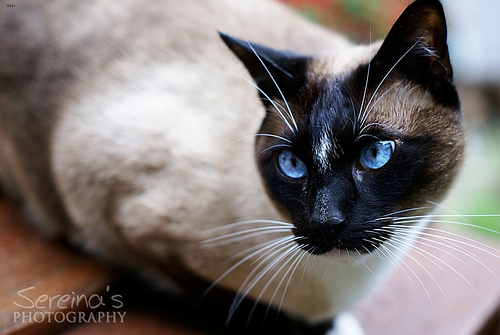

In [14]:
from IPython.display import Image
Image(filename=files[1]) 

## 1.2 Data Preprocessing: Data Loaders
Data loaders are a convenient way to get raw data into a shape and format that will be understood by deep learning models. They're essentially a reusable data preprocessing pipeline.

![Neural Network](https://www.tibco.com/sites/tibco/files/media_entity/2021-05/neutral-network-diagram.svg)

In [13]:
# How do we know if a file contains a cat? Simply because its name starts
# with a capital letter (this is a convention, of course; every dataset is
# created with such conventions)
def is_cat(filename):
    return filename[0].isupper()

In [16]:
loaders = ImageDataLoaders.from_name_func(
    path, 
    get_image_files(path), 
    valid_pct=0.2, # validation test size (as a percentage of total dataset size)
    seed=42, # a PRNG seed (for the random split between train and validation sets)
    label_func=is_cat,
    # this is how we tell fastai which transformations to apply to each individual image
    # when loading them from disk
    item_tfms=Resize(224) # item_tfms => item_transforms
)
# PRNG: Pseudo-Random Number Generator

Building a data loader can take several parameters to customize various aspects of the data preprocessing pipeline. You don't always need to specify all of them, since `fastai` provides reasonable defaults for most of them (you can see this if you execute `ImageDataLoaders.from_path_func??` in a cell)

### Data Loaders as Preprocessing Functions
Ultimately, a data loader is nothing but a data preprocessing function with the following signature:

`File Paths` -> `[Data Loader]` -> `Iterable[(X:tensor, Y:tensor)]`

To verify this, we can call the `one_batch` method and see that the result is a tuple of the form `(X:tensor, Y:tensor)`.

In [20]:
X, Y = loaders.one_batch()
type(X), type(Y)

(fastai.torch_core.TensorImage, fastai.torch_core.TensorCategory)

### Tensors
Tensors are the basic data structures that contains the data in all Deep Learning models. They're conceptually simple:

In [19]:
type(X), X.shape, type(Y), Y.shape

(fastai.torch_core.TensorImage,
 torch.Size([64, 3, 224, 224]),
 fastai.torch_core.TensorCategory,
 torch.Size([64]))

![Tensors](https://miro.medium.com/max/654/1*8jdzMrA33Leu3j3F6A8a3w.png)

### Batched Input

Data loaders also implement the `__iter__` protocol in Python, each time returning a batch (in later chapters we'll learn why processing data in batches is a good idea.)

This explains why if you do `len(loaders.train)` you won't get the total number of training samples, but rather the total number of batches:

In [8]:
len(loaders.train), type(loaders.train)

(92, fastai.data.core.TfmdDL)

Since we know that `X.shape[0]` contains the number of samples in a batch, we can compute the total number of items in the dataset as follows (*beware that this is slow, as it is actually loading the data into tensors!*)

In [9]:
sum(X.shape[0] for X, Y in loaders.train)

5888

In [10]:
sum(X.shape[0] for X, Y in loaders.valid)

1478

***
**ASIDE**

🤔 Why do we need *both* `path` and `get_image_files(path)`?

Something I found initially confusing was why *both* `path` and `get_image_files(path)` need to be passed as arguments. At first glance, it would seem like only the second one is needed. 

For the example above, that's indeed the case since all paths returned by `get_image_files(path)` are absolute. However, when the paths passed are relative, it is necessary to have an object path to help us produce absolute paths (after all, we can only read files when we have their absolute paths.)
***

### Visualizing Proprocessed Data

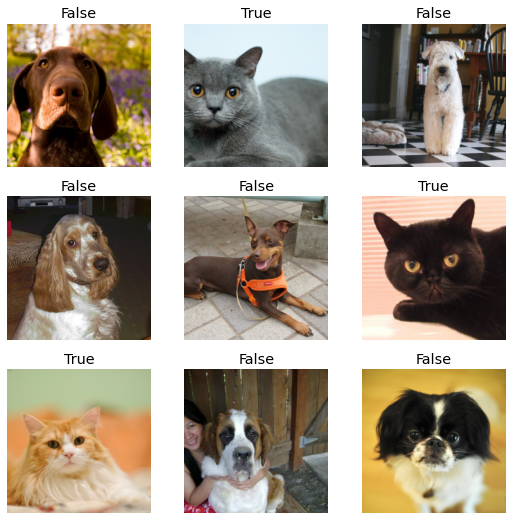

In [21]:
loaders.train.show_batch()

## 1.3 Training the Model

In [22]:
# resnet34 is a pre-trained vision model that will allow us to save a lot of time and 
# computing resources. Leveraging such a model is called transfer learning.

model = cnn_learner(loaders, resnet34, metrics=error_rate)

# Train the head of the model for `freeze_epochs` and then train the whole model for
# `epochs` using discriminative learning rates (i.e., different rates for different
# parts of the model) 
#
# -- How did I learn this? By executing `learn.fine_tune?`
model.fine_tune(epochs=1, freeze_epochs=2)

/opt/conda/envs/fastai/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch,train_loss,valid_loss,error_rate,time
0,0.178650,0.019761,0.008796,00:30
1,0.067461,0.018286,0.004736,00:29


epoch,train_loss,valid_loss,error_rate,time
0,0.041168,0.018336,0.006766,00:38


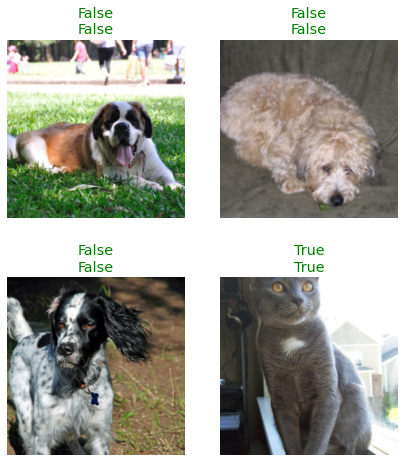

In [24]:
model.show_results(max_n=4, figsize=(7,8))

## 1.4 Transfer Learning
How did we manage to create a good classifier so quickly? The answer is a technique known as **Transfer Learning**. We'll more about the details of this technique and how it's implemented in `fastai` in future chapters.

![Transfer Learning](https://miro.medium.com/max/1400/1*f2_PnaPgA9iC5bpQaTroRw.png)

## 1.5 Model Errors Analysis
No model we ever build will be perfect, so it's important to have tools to analyze the mistakes made by our models. `fastai` provides several useful utilities for this purpose:

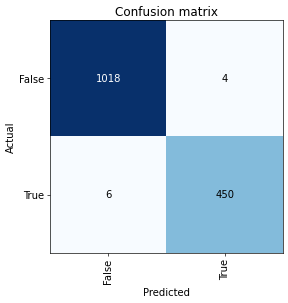

In [26]:
interpretation = ClassificationInterpretation.from_learner(model)
interpretation.plot_confusion_matrix(figsize=(5, 5), dpi=60)

In this example, the confusion matrix is very simple, but when dealing with larger multi-category problems, it's useful to directly see the categories for which the model is having most trouble by using the `most_confused` method:

In [27]:
interpretation.most_confused()

[(True, False, 6), (False, True, 4)]

# 2. Semantic Image Segmentation
Our next example concerns the problem of semantic segmentation in an image, i.e., the identification of objects and their boundaries at the pixel level.

![](https://theaisummer.com/static/8b58a02198e13d2e29a41b40e7c6a035/14b42/semseg.jpg)

## 2.1 Input Data Exploration

In [43]:
root_path = untar_data(URLs.CAMVID_TINY)

In [44]:
files = get_image_files(root_path/'images'); files

(#100) [Path('/root/.fastai/data/camvid_tiny/images/Seq05VD_f00210.png'),Path('/root/.fastai/data/camvid_tiny/images/Seq05VD_f02880.png'),Path('/root/.fastai/data/camvid_tiny/images/0006R0_f03720.png'),Path('/root/.fastai/data/camvid_tiny/images/0016E5_08093.png'),Path('/root/.fastai/data/camvid_tiny/images/Seq05VD_f00090.png'),Path('/root/.fastai/data/camvid_tiny/images/0016E5_05190.png'),Path('/root/.fastai/data/camvid_tiny/images/Seq05VD_f03060.png'),Path('/root/.fastai/data/camvid_tiny/images/0016E5_06240.png'),Path('/root/.fastai/data/camvid_tiny/images/0001TP_008400.png'),Path('/root/.fastai/data/camvid_tiny/images/Seq05VD_f02370.png')...]

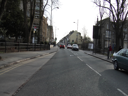

In [36]:
Image(filename=files[0])

### 2.1.1 Image Masks as Labels

This segmentation problem requires more sophisticated labels than the previous classification problem. In fact, the labels are images with the same shape as the input images, but with each pixel containing a value in the limited range `[0, K]` where `K` is the number of categories of objects of interest.

Let's see what one of these labels looks like:

In [37]:
!pip install imageio

     |████████████████████████████████| 3.4 MB 23.4 MB/s eta 0:00:01
     |████████████████████████████████| 3.1 MB 33.8 MB/s eta 0:00:01
  Attempting uninstall: pillow
    Found existing installation: Pillow 8.0.1
    Uninstalling Pillow-8.0.1:
      Successfully uninstalled Pillow-8.0.1
You should consider upgrading via the '/opt/conda/envs/fastai/bin/python3.8 -m pip install --upgrade pip' command.


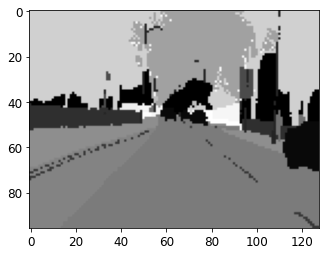

In [45]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import imageio

def get_label_filepath(root_path, filepath):
    return root_path/'labels'/f'{filepath.stem}_P{filepath.suffix}'

img_path = get_label_filepath(root_path, files[0])
img = imageio.v3.imread(img_path)
plt.imshow(img, cmap = cm.gray)

We can also plot a histogram of the values in the image to notice that we have 31 values (this is exactly the number of object categories in our dataset, as we'll see in a moment...)

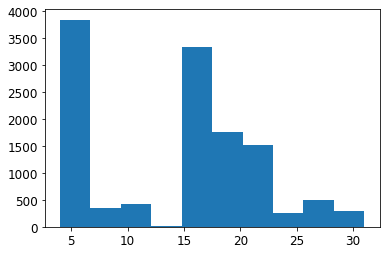

In [39]:
bin_counts, bin_edges, patches = plt.hist(img.ravel())

## 2.2. Data Loaders for Segmentation

In [46]:
loaders = SegmentationDataLoaders.from_label_func(
    root_path,
    bs=8, # batch size
    fnames=get_image_files(path/'images'),
    label_func=lambda filepath: get_label_filepath(root_path, filepath),
    codes=np.loadtxt(path/'codes.txt', dtype=str))

Notice how in this case our labels are also images, but they are image "masks" of the expected segmentation. This means that each label is an image where pixels have values in a limited range of values, and these values simply encode the categories that we can find in the `codes.txt` file:

In [47]:
categories = np.loadtxt(path/'codes.txt', dtype=str); 
len(categories), categories

(32,
 array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter',
        'OtherMoving', 'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone', 'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel',
        'VegetationMisc', 'Void', 'Wall'], dtype='<U17'))

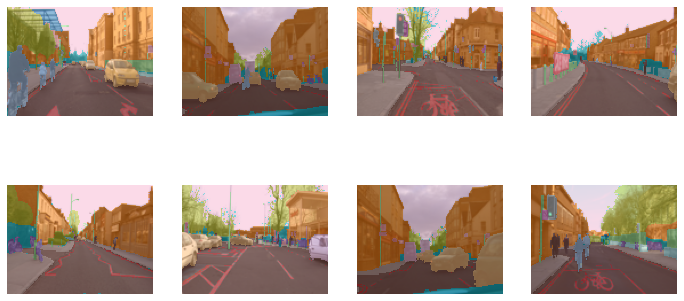

In [48]:
loaders.train.show_batch()

## 2.3 Training the Model

In [49]:
# resnet34 is being used as a feature extractor
learn = unet_learner(loaders, resnet34)

# Fine-tune model's head for 1 epoch, and then train the whole model for 8 epochs
# with discriminative learning rates
learn.fine_tune(epochs=8, freeze_epochs=1)

epoch,train_loss,valid_loss,time
0,2.719476,2.600324,00:02


epoch,train_loss,valid_loss,time
0,1.936736,1.563897,00:02
1,1.666078,1.386278,00:02
2,1.470923,1.009166,00:02
3,1.291669,1.106818,00:02
4,1.183264,0.938595,00:02
5,1.079087,0.809942,00:03
6,0.986732,0.775056,00:02
7,0.914212,0.767789,00:02


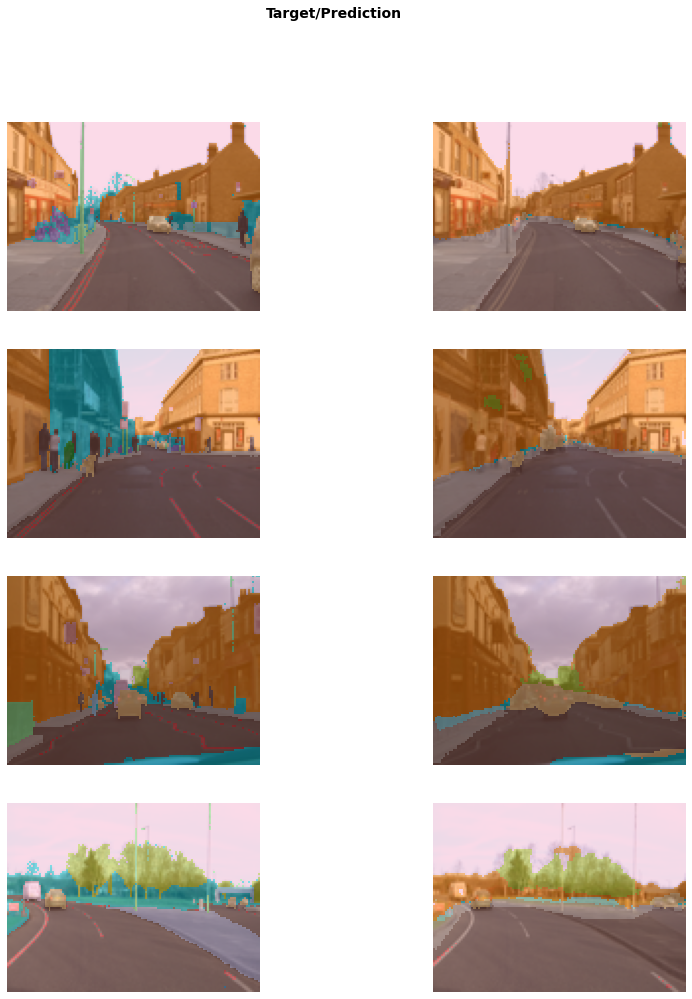

In [53]:
learn.show_results(max_n=4, figsize=(7*2,8*2))

# 3. Sentiment Classification
For our next example, we'll see how to create a text sentiment classifier that predicts whether a moview review is positive or negative.

![Sentiment Classification](https://www.freecodecamp.org/news/content/images/2020/09/wall-5.jpeg)

## 3.1 Exploring the Input Data

In [54]:
from fastai.text.all import *

In [55]:
path = untar_data(URLs.IMDB)

In [57]:
path, path.ls()

(Path('/root/.fastai/data/imdb'),
 (#8) [Path('/root/.fastai/data/imdb/imdb.vocab'),Path('/root/.fastai/data/imdb/models'),Path('/root/.fastai/data/imdb/tmp_lm'),Path('/root/.fastai/data/imdb/train'),Path('/root/.fastai/data/imdb/unsup'),Path('/root/.fastai/data/imdb/tmp_clas'),Path('/root/.fastai/data/imdb/test'),Path('/root/.fastai/data/imdb/README')])

In [59]:
!cat /root/.fastai/data/imdb/README

Large Movie Review Dataset v1.0

Overview

This dataset contains movie reviews along with their associated binary
sentiment polarity labels. It is intended to serve as a benchmark for
sentiment classification. This document outlines how the dataset was
gathered, and how to use the files provided. 

Dataset 

The core dataset contains 50,000 reviews split evenly into 25k train
and 25k test sets. The overall distribution of labels is balanced (25k
pos and 25k neg). We also include an additional 50,000 unlabeled
documents for unsupervised learning. 

In the entire collection, no more than 30 reviews are allowed for any
given movie because reviews for the same movie tend to have correlated
ratings. Further, the train and test sets contain a disjoint set of
movies, so no significant performance is obtained by memorizing
movie-unique terms and their associated with observed labels.  In the
labeled train/test sets, a negative review has a score <= 4 out of 10,
and a positive review has a scor

In [30]:
# by default, this loader expects validation data in a `valid` folder
loaders = TextDataLoaders.from_folder(path, valid='test')
loaders.train.show_batch()

,text,category
0,"xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules of the match , both opponents have to go through tables in order to get the win . xxmaj benoit and xxmaj guerrero heated up early on by taking turns hammering first xxmaj spike and then xxmaj bubba xxmaj ray . a xxmaj german xxunk by xxmaj benoit to xxmaj bubba took the wind out of the xxmaj dudley brother . xxmaj spike tried to help his brother , but the referee restrained him while xxmaj benoit and xxmaj guerrero",pos
1,"xxbos xxmaj here are the matches . . . ( adv . = advantage ) \n\n xxmaj the xxmaj warriors ( ultimate xxmaj warrior , xxmaj texas xxmaj tornado and xxmaj legion of xxmaj doom ) v xxmaj the xxmaj perfect xxmaj team ( mr xxmaj perfect , xxmaj ax , xxmaj smash and xxmaj crush of xxmaj demolition ) : xxmaj ax is the first to go in seconds when xxmaj warrior splashes him for the pin ( 4 - 3 adv . xxmaj warriors ) . i knew xxmaj ax was n't a healthy man but if he was that unhealthy why bother have him on the card ? xxmaj this would be his last xxup ppv . xxmaj eventually , both xxmaj legion of xxmaj doom and xxmaj demolition job out cheaply via double disqualification ( 2 - 1 adv . xxmaj warriors ) . xxmaj perfect",neg
2,"xxbos xxrep 3 * xxup spoilers xxrep 3 * xxrep 3 * xxup spoilers xxrep 3 * xxmaj continued … \n\n xxmaj from here on in the whole movie collapses in on itself . xxmaj first we meet a rogue program with the indication we 're gon na get ghosts and vampires and werewolves and the like . xxmaj we get a guy with a retarded accent talking endless garbage , two ' ghosts ' that serve no real purpose and have no character what - so - ever and a bunch of henchmen . xxmaj someone 's told me they 're vampires ( straight out of xxmaj blade 2 ) , but they 're so undefined i did n't realise . \n\n xxmaj the funny accented guy with a ridiculous name suffers the same problem as the xxmaj oracle , only for far longer and far far worse .",neg
3,"xxbos xxmaj i 've rented and watched this movie for the 1st time on xxup dvd without reading any reviews about it . xxmaj so , after 15 minutes of watching xxmaj i 've noticed that something is wrong with this movie ; it 's xxup terrible ! i mean , in the trailers it looked scary and serious ! \n\n i think that xxmaj eli xxmaj roth ( mr . xxmaj director ) thought that if all the characters in this film were stupid , the movie would be funny … ( so stupid , it 's funny … ? xxup wrong ! ) xxmaj he should watch and learn from better horror - comedies such xxunk xxmaj night "" , "" the xxmaj lost xxmaj boys "" and "" the xxmaj return xxmaj of the xxmaj living xxmaj dead "" ! xxmaj those are funny ! \n\n """,neg
4,"xxbos 8 xxmaj simple xxmaj rules for xxmaj dating xxmaj my xxmaj teenage xxmaj daughter had an auspicious start . xxmaj the supremely - talented xxmaj tom xxmaj shadyac was involved in the project . xxmaj this meant that the comedy would be nothing less of spectacular , and that 's exactly what happened : the show remains one of the freshest , funniest , wittiest shows made in a very long time . xxmaj every line , facial expression , casting choice , scene , all wreaked of perfection . xxmaj there was not one episode after which i thought , "" man that was n't as good as the rest "" . xxmaj each one was a standout . xxmaj again , this is the kind of perfectionism that we 've come to expect from xxmaj tom . xxmaj for those who do n't know , xxmaj tom",pos
5,"xxbos xxmaj god ! xxmaj zorro has been the the subject of about as many movies as xxmaj tarzan , and probably had about as many actors in the title role . \n\n xxmaj this xxmaj serial is one of my own personal f

### Special Tokens
As you can see, the data preprocessing adds a couple of additional things to the input: those `xx--` words you see are actually special tokens that indicate things like "beginning of stream" (`xxbos`) or "capitalized word" (`xxmaj`). These are useful for the model to more easily capture certain relationships in the data that improve its predictions at inference time.

## 3.2 Training the Model

In [31]:
model = text_classifier_learner(
    loaders, 
    # See https://paperswithcode.com/method/awd-lstm for details on this model;
    # For a primer on LSTMs, see https://colah.github.io/posts/2015-08-Understanding-LSTMs/
    AWD_LSTM,
    # `drop_mult` controls the probability of "dropout" applied in various
    # parts of the model (we'll see what this technique is about later on)
    drop_mult=0.5, 
    metrics=accuracy
)
model.fine_tune(4, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.461490,0.393011,0.823160,02:22


epoch,train_loss,valid_loss,accuracy,time
0,0.311721,0.324508,0.874840,04:46
1,0.242824,0.198422,0.921800,04:46
2,0.191902,0.185533,0.929360,04:46
3,0.141599,0.188326,0.929160,04:46


Something worth noting is that training LSTMs (which are a special kind of RNN -- Recurrent Neural Network) is specially slow. This is because of their sequential architecture. 

In recent years, LSTMs have been replaced by Transformers which can train much faster. Although Transformers didn't initially improve accuracy of existing RNN-based models, their faster training was a game changer in practice. 

Large and famous language models today (such as GPT-3, LaMDA, etc.) use the Transformer architecture. We won't study that architecture during this course, but if you're interested you can take the [FastAI NLP Course](https://www.fast.ai/2019/07/08/fastai-nlp/), which does dedicate a full chapter to it.

In [32]:
sentiment, category, distribution = model.predict("I really liked that movie!")
sentiment, category, distribution

('pos', tensor(1), tensor([2.3638e-04, 9.9976e-01]))

In [33]:
sum(distribution)

tensor(1.)

In the prediction above, we can see three things:
    
+ A prediction ('pos' for positive sentiment)
+ A categorical and numeric value associated with that prediction (1)
+ The probability distribution of the predictions (in this case, we see that the model has 0.999% confidence in its prediction)

## 3.3 Human Inspection
It's always important to run human trials on a model to detect its weaknesses. While passing a benchmark test with flying colors is a necessary condition for any model, it's important to keep in mind that many such benchmarks can be quite limited in terms of the expected behavior in production.

For example, the previous model was trained mostly on relatively long movie reviews. Will the model generalize well enough when a review is very short (e.g., a sentence)? Let's see:

In [34]:
sentiment, category, distribution = model.predict("This movie made me wanna run for the hills")
sentiment, category, distribution

('pos', tensor(1), tensor([0.0048, 0.9952]))

In [35]:
sentiment, category, distribution = model.predict("I have seen much better movies")
sentiment, category, distribution

('pos', tensor(1), tensor([0.0365, 0.9635]))

In [36]:
sentiment, category, distribution = model.predict("Prepare for a long sequence of cheap thrills")
sentiment, category, distribution

('pos', tensor(1), tensor([0.4538, 0.5462]))

# 4. Tabular Data
`fastai` also provides support to train classifiers and regressors of more "classical" kinds of data, namely "tabular" data. We won't get into details in this chapter, though.

![Tabular Data](https://i.ytimg.com/vi/ILTfP3jdVKo/maxresdefault.jpg)

In [60]:
from fastai.tabular.all import *

In [61]:
path = untar_data(URLs.ADULT_SAMPLE)

In [63]:
loaders = TabularDataLoaders.from_csv(
    path/'adult.csv', path=path, 
    y_names="salary",
    cat_names=["workclass", "education", "marital-status", "occupation", "relationship", "race"],
    cont_names=["age", "fnlwgt", "education-num"],
    procs=[Categorify, FillMissing, Normalize])

In [64]:
loaders.train.show_batch()

,workclass,education,marital-status,occupation,relationship,race,education-num_na,age,fnlwgt,education-num,salary
0,Private,Assoc-acdm,Never-married,Craft-repair,Not-in-family,White,False,24.000000,180059.999822,12.0,<50k
1,Private,Assoc-voc,Married-civ-spouse,Exec-managerial,Husband,White,False,56.000001,367983.996383,11.0,>=50k
2,Private,Bachelors,Divorced,Sales,Own-child,White,False,36.000000,279615.002986,13.0,<50k
3,Local-gov,Masters,Married-civ-spouse,Prof-specialty,Wife,White,False,44.000000,101966.997799,14.0,<50k
4,Private,Some-college,Never-married,Craft-repair,Own-child,Asian-Pac-Islander,False,41.000000,82392.997741,10.0,<50k
5,Private,HS-grad,Never-married,Handlers-cleaners,Not-in-family,Black,False,27.000000,73586.997199,9.0,<50k
6,?,5th-6th,Married-civ-spouse,?,Husband,Black,False,51.000000,157327.000405,3.0,<50k
7,Private,Some-college,Divorced,Prof-specialty,Own-child,White,False,27.000000,217379.000658,10.0,<50k
8,Private,1st-4th,Married-civ-spouse,Handlers-cleaners,Husband,White,False,33.000000,231826.000177,2.0,<50k
9,Private,HS-grad,Never-married,Farming-fishing,Unmarried,White,False,31.000000,241884.998660,9.0,<50k


In [65]:
model = tabular_learner(loaders, metrics=accuracy)
learn.fit_one_cycle(n_epoch=3)

epoch,train_loss,valid_loss,accuracy,time
0,0.382868,0.376664,0.824939,00:06
1,0.365777,0.354346,0.836302,00:06
2,0.355633,0.349006,0.838759,00:06


***
⚠️ Beware that just because one can process tabular data using deep learning models, it doesn't mean that's the best kind of model to use. In practice, it is often the case that, for tabular data, models such as [`XGBoost`](https://xgboost.readthedocs.io/en/stable/) can easily beat the performance of deep learning models.
***

# 5. Collaborative Filtering (Recommendation Systems)
Our final example concerns the problem of making recommendations of products to users based on previous ratings of products given by users (hence the name "collaborative")

![Collaborative Filtering](https://developers.google.com/machine-learning/recommendation/images/Matrixfactor.svg)

A few key things about these systems:

+ **Latent Factors Representation** -- They assume that the rating of a product can be expressed as a dot product of vectors representing hidden (latent) factors (e.g., for movies, this could be whether a user likes action, comedy, etc.; and whether a given movie contains elements of action, comedy, etc.)


+ **Sparsity** -- They tend to be sparse, since most systems in production have a hard time convincing people to provide ratings. In many cases, such ratings must be inferred (e.g., by proxies such as whether the person watched the movie beginning to end without interruptions; whether they've watched the movie several times; whether they've watched movies that are considered quite related)

For more details, see [this article](https://developers.google.com/machine-learning/recommendation/collaborative/matrix)

In [66]:
from fastai.collab import *

path = untar_data(URLs.ML_SAMPLE)
loaders = CollabDataLoaders.from_csv(path/'ratings.csv')

In [67]:
loaders.show_batch()

,userId,movieId,rating
0,654,6377,5.0
1,509,1036,2.5
2,294,318,3.0
3,457,858,4.0
4,463,2628,1.0
5,294,592,3.0
6,380,32,5.0
7,382,588,3.0
8,353,500,1.0
9,176,5349,3.0


The above is the ratings matrix in a compact form. `fastai` makes it really easy to take this and figure out the latent factors that are most consistent with the known ratings:

In [68]:
model = collab_learner(loaders, y_range=(0.5, 5.5))
model.fine_tune(10)

epoch,train_loss,valid_loss,time
0,1.493464,1.451433,00:00


epoch,train_loss,valid_loss,time
0,1.349556,1.389597,00:00
1,1.236543,1.198095,00:00
2,1.005754,0.876822,00:00
3,0.801103,0.725302,00:00
4,0.698310,0.679998,00:00
5,0.651629,0.665123,00:00
6,0.636674,0.658805,00:00
7,0.632669,0.655281,00:00
8,0.619340,0.654012,00:00
9,0.612880,0.653867,00:00


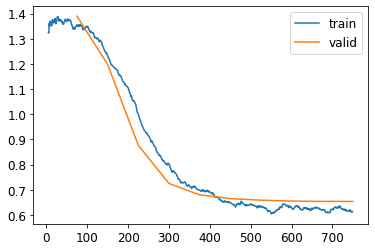

In [69]:
model.recorder.plot_loss()

***
( ͡☉ ͜ʖ ͡☉)

The shape of this plot is a bit fishy: why is the validation loss consistently lower than the training loss? Some possible explanations are given in [this post](https://towardsdatascience.com/what-your-validation-loss-is-lower-than-your-training-loss-this-is-why-5e92e0b1747e).
***

In [70]:
model.show_results()

,userId,movieId,rating,rating_pred
0,100.0,88.0,4.0,4.059463
1,85.0,6.0,4.0,4.750044
2,65.0,45.0,4.0,4.316584
3,38.0,56.0,5.0,4.482288
4,19.0,23.0,2.0,3.207524
5,93.0,15.0,3.0,4.250358
6,4.0,90.0,3.5,3.854330
7,38.0,22.0,4.0,3.891664
8,26.0,73.0,3.5,4.143072


# Questions

**1. Do you need these for deep learning?**
+ Lots of math
    - No, unless you want to go beyond being a practioner (e.g., a researcher who creates new models)
+ Lots of data
    - Not necessarily, but it depends. If your problem happens to have something in common with large pre-trained models (e.g., your doing image classification), you can use transfer learning with "small data".
+ Lots of expensive computers
    - In general no. There are many affordable options to get good on-demand computing resources (e.g., [Google Collab](https://colab.research.google.com/), [Paperspace](https://www.paperspace.com/), AWS Sagemaker, etc.). That said, models on the bleeding edge of technology may require huge amounts of computation, but it's usually the case that equivalent but less "expensive" models are published soon afterward.
+ A PhD
    - No, particularly if your goal is to become a practioner. High-quality materials and affordable compute is available to the average person on the Internet.

**2. Name five areas where deep learning is now the best tool in the world.**
+ Human language translation
+ Image classification
+ Natural language "understanding" (answering questions and making summaries)
+ Game playing (Chess, Go)
+ Speech recognition (automatic captioning for audio and videos)

Note that the fact that deep learning is now the best tool in these areas doesn't necessarily mean that it beats human performance (though that's actually the case in some cases, such as game playing)

**3. What was the name of the first device that was based on the principle of the artificial neuron?**
The [Mark I Perceptron](https://news.cornell.edu/stories/2019/09/professors-perceptron-paved-way-ai-60-years-too-soon), which implemented the perceptron model.

**4. Based on the book of the same name, what are the requirements for parallel distributed processing (PDP)?**
+ A set of units of computation
+ An activation rule for each unit (in practice shared by all units)
+ A state of activation for each unit
+ A connectivity pattern between units (the architecture)
+ A learning rule that leverages experience to modify connectivity among the units
+ An output function for each unit
+ An environment in which the system operates

**5. What where the two theoretical misunderstandings that held back the field of neural networks?**

One was that early perceptrons (the simplest form of a neural network with a single layer) couldn't learn the XOR function.

The second one is probably attributable to the universal approximation theorem that applies to NN with two layers. While theoretically that's all you need to approximate any function, in practice they're very expensive to train and require prohibitive amounts of data. The solution --more layers-- was known for many years but it was never thought seriously enough, so few people tried to explore it in detail.

Another one --although not really theoretical-- was the widely held belief that NN couldn't scale to larger problems because at the time there weren't enough data and compute power available.

**6. What is a GPU?**

It's a processing unit specialized to run certain mathematical instructions that are typically needed in video games (e.g., matrix multiplications). As it turns out, ML models also use matrix operations at their core, so they can leverage GPUs to train much faster than using CPUs.

**10. Why is hard to use a traditional computer program to recognize images in a photo?**

Because there is too much variability in detail in most images of the same thing. Think about how, if compared pixel by pixel, even two pictures of the same object will vary significantly as light conditions, shot angle, shot distance, etc., vary. Capturing all these varying details in a simple set of hand-written rules is extremely hard, and when it's been done it results in very brittle programs.

**11. What did Samuel mean by "weight assignment"?**

He referred to the importnace given to each feature used to evaluate a position in his game of checkers.

**12. What term do we normally use in deep learning for what Samuel called "weights"?**

"Parameters", although the term "weights" has gained popularity recently as well.

**13. Draw a picture that summarizes Samuel's view of a machine learning model**

![Machine Learning Model](https://wttech.blog/static/9332307bdf37204094e4497aec4016c7/3075e/arthur-samuel-ml.png)

**14. Why is hard to understand why a deep learning model makes a particular prediction?**

Because what led the model to make a given prediction (individual neuron activations, or groups of them) can be distributed across layers in the model. Also, features learned by the model aren't always human-interpretable because the learning algorithm doesn't use such constraints. Instead, it uses whatever features help it maximize its prediction ability, regardless of whether they're understandable by humans.

**15. What is the name of theorem that shows that a neural network can solve any mathematical problem to any level of accuracy?**

The universal approximation theorem for neural networks.

**16. What do you need in order to train a model?**

+ Labeled data, i.e., `(X, Y)` pairs
+ An error measure (if there is not one specific to your problem, we can default to an analytic one)
+ A learning algorithm (e.g., SGD or BSGD)
+ A hypothesis set (e.g., neural nets or decision trees)

**17. How could a feedback loop impact the rollout of a predictive policing model?**

Current models are limited in their knowledge about the world and can't reason on their own as humans can. They simply learn what is being taught to them. Think of it as training a dog to do things that are not natural to them. 

In particular, models learn whatever biases are encoded in the training data that you feed them. So when you use them to make decisions in the real world, they will exhibit those biases and, if left unchecked, they can amplify the biases even further. If the data resulting from these biased decisions is later input to subsequent versions of the model, we will likely see another round of amplification of the biases.

For the case of predictive policing, consider a situation where the data indicates the locations of previous arrests, which is not the same as where crime is happening. A model fed with this data might then suggest more policing in similar areas, perhaps leading to increased arrests and further amplifying the bias (e.g., "crimes happen more often in poor neighborhoods with minority demographics") and the social stigmatization.

The general public --who tends to believe that algorithms are more neutral than humans-- would now have a "piece of evidence" that some biases are not a social prejudice only, where in fact this has only proven that algorithms can help to significantly amplify human biases.

**18. Do we always have to use 224x224-pixel images with the cat recognition model?**

No, but there's a tradeoff. Using smaller images may lead to less accurate predictions due to lack of sufficient detail to extract important features. Using larger images may lead to better prediction accuracy (beware of overfitting, though!) but the cost is more processing time and memory.

**19. What is the difference between classification and regression?**

Classification models work on problems with discrete outputs (i.e., categories). Regression models work on problems with continuous outputs (i.e., real numbers)

**20. What is a validation set? What is a test set? Why do we need them?**

Both are neded to ensure that our model doesn't just memorize the training dataset (overfitting). The validation set is used to help adjust training parameters (hyper parameters), while the test set allows us to assert our best guess for the models performance when used in production (i.e., to get an estimate of the generalization error)

**21. What will `fastai` do if you don't provide a validation set?**

It will take 20% of the training data for that purpose (unless you override that percentage via the corresponding configuration option)

**22. Can we always use a random sample for a validation set? Why or why not?**

No. For sequence data it is incorrect because the model would not be forced to learn high-level patterns. It would probably just learn local patterns (i.e., trivial interpolations), rendering it useless to predict future points.

**23. What is overfitting? Provide an example**

It's when a model doesn't really learn a stable underlying pattern in the training data. Instead, it learns too many irrelevant details (i.e., noise), resulting in poor generalization ability. An example is when we humans learn a second language, but we are only exposed to a very specific accent. Then, when we hear people with other accents, we are dumbfounded and can barely understand them. This means during our learning, our brain used features which do not generalize.

**24. What is a metric? How does it differ from loss?**

It's an error measure that's interpretable and useful for humans. A loss is also an error measure but is meant to be used by the training algorithm (e.g., if using SGD, it must be differentiable and should vary according to the model's predictions confidence, even when the human metric stays the same).

Despite those differences, a loss function is generally expected to be positively correlated with the human metric.

**25. How can pretrained models help?**

They help us save time and resources by not having to learn general features from scratch. The world is compositional, so most objects share a lot of low-level features when projected as images or sounds (e.g., geometric shapes, textures, notes). If we trained models from scratch every time, we'd be learning the same features again and again.

**26. What is the "head" of a model?**

It refers to the last few layers which typically perform a specific tasks (like classification) based on features detected on earlier layers.

**27. What kinds of features do the early layers of a CNN find? How about the later layers?**

Early layers specialize in low-level features like lines, arcs, simple textures, etc., while subsequent layers build upon previous ones creating higher-level representations, such as geometric shapes, complex texture patterns, and eventually objects like faces, wheels, dogs, etc.

**28. Are image models useful only for photos?**

No. Sometimes problems in other domains can be mapped to the visual domain, preserving useful information from the original problem while making it easy to process with vision models like CNNs. This is an example of a mapping that finds a useful representation of the data by reducing the problem to another domain.

**29. What is an architecture?**

It's the pattern of connectivity among processing units and more generally among layers of them.

**30. What is segmentation?**

It's classification at the level of individual pixels in an image. Every pixel is mapped to the object category that it belongs to.

**31. What is `y_range` used for? When do we need it?**

It's a kind of normalization that ensures that a numeric value gets mapped to a specific range (similar to how a sigmoid maps real values to the `(0, 1)` range)

We use it whenever the expected output is in a specific range, forcing us to normalize the raw output for comparison purposes.

**32. What are hyperparameters?**

They're the learning algorithm parameters that we use to search for the "right" parameters of a model. Therefore, they only matter during training, and they should not be confused with parameters of the model itself.

**33. What's the best way to avoid failures when using AI in an organization?**

1. It's important to keep an untainted test set that is kept secret from teams developing the model (either in-house or outsourced contractors). This will ensure that you can get an unbiased assessment of the ultimate model's performance before deployment. The process to generate that test set is also important to prevent data leakage.

2. Equally important is to define a meaningful metric.

3. Another important point is to ensure that rollout is controlled.

# Further Research

**1. Why is a GPU useful for deep learning? How is a CPU different, and why is it less effective for deep learning?**

CPUs are general-purpose processing units, whereas GPUs are specialized in certain kinds of computations. Moreover, GPUs have typically thousands of cores (over 10,000 at the time of writing) while CPUs tend to have much fewer cores (typically 8 to 16). 

So GPUs can do parallel work more efficiently, but its actual effectiveness depends on the type of workload a program has, of course. For [embarrassingly parallel](https://en.wikipedia.org/wiki/Embarrassingly_parallel) tasks GPUs are great. Certain operations, such as matrix multiplications, lend themselves very well to this paradigm.

Deep learning uses at its core thousands of tensor operations, which include matrix multiplications, so GPUs are naturally a great fit for training efficiently.

**2. Try to think of three areas where feedback loops might impact the use of machine learning. See if you can find documented examples of that happening in practice.**

**Recommendation engines in social media**. 

If engagement is the metric to optimize, it's possible that recommendations will be made for content that is addictive in nature. Consider the case of conspiracy theory videos on YouTube. People who consume such content tend to spend far more time online than the average user. This could be a signal for the engine that the content is engaging, so more similar content will be served in the future to those users, and perhaps even to some other unrelated users.

As more of this content is served, these users might exacerbate their views on conspiracy theories and get a false sense that those views are far more common than they really are. In other words, they might start creating a reality distortion field and an echo chamber for these users.

The biases in recommendation engines and the problems they can cause are amply documented, as attested by just some of the top results of a Google search:

+ [YouTube algorithm creates echo chambers](https://blogs.cornell.edu/info2040/2019/09/19/youtubes-algorithm-creates-echo-chambers/)

+ [YouTube algorithm recommends videos you wish you hadn't seen](https://www.zdnet.com/article/youtubes-algorithm-is-still-recommending-videos-that-you-wish-you-hadnt-seen-say-researchers/)

**Prescreening of work resumes**

Assume that the model was initially built using data from past screenings in a company with a bias for white males. The resulting model will then learn that bias, and as it is applied to new applicants it will generate new training data (indirectly, of course) which could be used to train future versions of the model. That will very likely amplify the original bias, creating a vicious cycle.

Such tools already exist in the marketplace and while they clearly offer some value for companies, their risks should also be considered. As [this article](https://vervoe.com/ai-in-resume-screening/) online mentions:

> If not implemented properly, AI tools can replicate some of the same biases that recruiters bring to the resume review. AI systems are really only as good as the data used to train them by the people who built them. When hiring teams use historical data to train machine learning tools, such as data collected from the company’s internal database, then the system inherits the biases of recruiters who previously vetted those candidates.

**Game play bias amplification**

If we teach a game engine to play by watching human games, we may be limiting its potential by teaching it human biases. If other humans then learn from such engines, they will tend to repeat the biases even more by virtue of trusting that the engine knows best. This might limit exploration of counterintuitive but potentially powerful strategies.

AlphaZero has already [demonstrated this](https://www.technologyreview.com/2017/12/08/147199/alpha-zeros-alien-chess-shows-the-power-and-the-peculiarity-of-ai/) by playing chess that some humans call "alien", using strategies and moves that seem odd and not human-like.